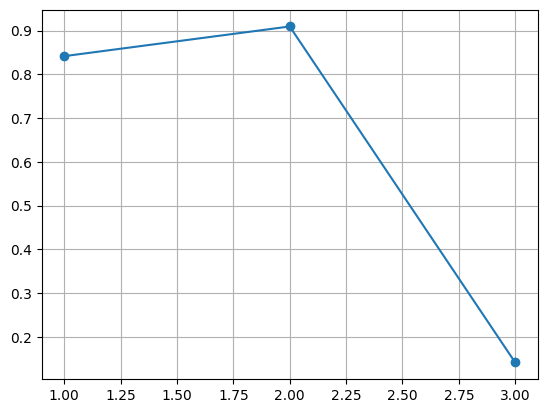

In [ ]:
from typing import Optional, List, Dict
import matplotlib.pyplot as plt
import numpy as np

def grid_handler(grid:bool=False):
    if grid:
        plt.grid()

def label_handler(labels:Optional[Dict[str, str]]=None):
    if labels:
        plt.xlabel(labels.get('xlabel', ''))
        plt.ylabel(labels.get('ylabel', ''))

class Plotter:
    def __init__(self, marker:str='o', line_style:str='-', labels: Optional[Dict[str, str]]=None):
        self.marker = marker
        self.line_style = line_style
        self.labels = labels

    def line_plotter(self, X:np.ndarray=None, y:np.ndarray=None, grid:bool=True):
        if X is None or y is None:
            raise ValueError("X and y must be provided for line_plotter")

        grid_handler(grid)
        label_handler(self.labels)
        plt.plot(X, y, marker=self.marker, ls=self.line_style)
        plt.show()

    def scatter_plotter(self, X:np.ndarray=None, y:np.ndarray=None, grid:bool=True):
        if X is None or y is None:
            raise ValueError("X and y must be provided for scatter_plotter")

        grid_handler(grid)
        label_handler(self.labels)
        plt.scatter(X, y)
        plt.show()

    def bar_plotter(self, x:List[str]=None, y:List[float]=None, grid:bool=True):
        if x is None or y is None:
            raise ValueError("x and y must be provided for bar_plotter")

        grid_handler(grid)
        label_handler(self.labels)
        plt.bar(x, y)
        plt.show()

    def histogram_plotter(self, data:np.ndarray=None, bins:int=10):
        if data is None:
            raise ValueError("data must be provided for histogram_plotter")

        plt.hist(data, bins=bins)
        plt.show()

    def pie_plotter(self, data:List[float]=None, labels:List[str]=None):
        if data is None:
            raise ValueError("data must be provided for pie_plotter")

        plt.pie(data, labels=labels, autopct='%1.1f%%')
        plt.show()

    def heatmap_plotter(self, data:np.ndarray=None):
        if data is None:
            raise ValueError("data must be provided for heatmap_plotter")

        plt.imshow(data, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.show()

x = np.array([1,2,3])
y = np.sin(x)
pl = Plotter()
pl.line_plotter(x, y)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from tensorflow.keras.layers import Input, Dense
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.svm import OneClassSVM
import pandas as pd
import numpy as np
import logging

logger = logging.getLogger(__name__)

class DataCleaner:
    def __init__(self, df:pd.DataFrame, verbose:bool=False):
        self.df = df.copy()
        self.features = df.columns.tolist()
        self.X = self.df[self.features].values
        self.verbose = verbose

    def detect_autoencoder(self, hidden_size:int=2, epochs:int=20, threshold:float=None) -> np.ndarray:
        input_dim = self.X.shape[1]
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(hidden_size, activation='relu',
            activity_regularizer=regularizers.l1(1e-5))(input_layer)

        decoded = Dense(input_dim, activation='linear')(encoded)
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(self.X, self.X, epochs=epochs, verbose=0)
        reconstructions = autoencoder.predict(self.X, verbose=0)
        errors = np.mean(np.square(self.X - reconstructions), axis=1)
        if threshold is None:
            threshold = np.percentile(errors, 95)

        mask = errors > threshold
        if self.verbose:
            logger.debug(f"[AE] Threshold={threshold:.4f}, Outliers={mask.sum()}")

        return np.array(mask)

    def detect_lof(self, contamination: float = 0.05) -> np.ndarray:
        lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
        pred = lof.fit_predict(self.X)
        mask = pred == -1
        if self.verbose:
            logger.debug(f"[LOF] Outliers={mask.sum()}")

        return np.array(mask)

    def detect_ocsvm(self, contamination: float = 0.05) -> np.ndarray:
        ocsvm = OneClassSVM(nu=contamination, kernel='rbf', gamma='auto')
        ocsvm.fit(self.X)
        pred = ocsvm.predict(self.X)
        mask = pred == -1
        if self.verbose:
            logger.debug(f"[OCSVM] Outliers={mask.sum()}")

        return np.array(mask)

    def detect_isoforest(self, contamination: float = 0.05) -> np.ndarray:
        iso = IsolationForest(contamination=contamination, random_state=42)
        iso.fit(self.X)
        pred = iso.predict(self.X)
        mask = pred == -1
        if self.verbose:
            logger.debug(f"[IsoForest] Outliers={mask.sum()}")

        return np.array(mask)

    def detect_zscore(self, threshold: float = 3.0) -> np.ndarray:
        z_scores = np.abs((self.X - np.mean(self.X, axis=0)) / np.std(self.X, axis=0))
        mask = (z_scores > threshold).any(axis=1)
        if self.verbose:
            logger.debug(f"[Z-score] Outliers={mask.sum()}")

        return np.array(mask)

    def detect_iqr(self, factor: float = 1.5) -> np.ndarray:
        Q1 = np.percentile(self.X, 25, axis=0)
        Q3 = np.percentile(self.X, 75, axis=0)
        IQR = Q3 - Q1
        mask = ((self.X < (Q1 - factor * IQR)) | (self.X > (Q3 + factor * IQR))).any(axis=1)
        if self.verbose:
            logger.debug(f"[IQR] Outliers={mask.sum()}")

        return np.array(mask)

    def clean(self, detect_method='iqr', replace=None, fill_missing=True) -> pd.DataFrame:
        method_map = {
            'ae': 'detect_autoencoder',
            'lof': 'detect_lof',
            'ocsvm': 'detect_ocsvm',
            'isoforest': 'detect_isoforest',
            'zscore': 'detect_zscore',
            'iqr': 'detect_iqr'
        }

        X_temp = self.df[self.features].copy()
        if fill_missing:
            X_temp = X_temp.fillna(X_temp.mean())

        mask = getattr(self, method_map[detect_method])()

        df_cleaned = self.df.copy()

        if replace in ['mean', 'median']:
            for col in self.features:
                if replace == 'mean':
                    df_cleaned.loc[mask, col] = df_cleaned[col].mean()

                else:
                    df_cleaned.loc[mask, col] = df_cleaned[col].median()
            if fill_missing:
                df_cleaned[self.features] = df_cleaned[self.features].fillna(df_cleaned[self.features].mean())

        elif replace in ['ffill', 'bfill']:
            df_cleaned.loc[mask, self.features] = np.nan
            if replace == 'ffill':
                df_cleaned = df_cleaned.ffill().bfill()

            else:
                df_cleaned = df_cleaned.bfill().ffill()

        elif replace and replace.startswith("percentile:"):
            try:
                p = float(replace.split(":")[1])
                for col in self.features:
                    thresh = np.percentile(df_cleaned[col], p)
                    df_cleaned.loc[mask, col] = thresh

            except Exception as e:
                logger.warning(f"Percentile replace failed: {e}")

            if fill_missing:
                df_cleaned[self.features] = df_cleaned[self.features].fillna(df_cleaned[self.features].mean())

        else:
            df_cleaned = df_cleaned.loc[~mask].dropna(subset=self.features).reset_index(drop=True)

        return df_cleaned

df = pd.DataFrame([1,2,3,4, 50])
dc = DataCleaner(df)
dc.clean(detect_method='iqr', replace='mean')

,0
0,1
1,2
2,3
3,4
4,12


In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import category_encoders as ce
import pandas as pd
import numpy as np

class FeatureAnalyze:
    def __init__(self, df:pd.DataFrame, X:np.ndarray, y:np.ndarray):
        self.df = df
        self.X = X
        self.y = y
        self.X_scaled = None
        self.scaler_model = None
        self.pca_model = None

    def scaler(self, mode: str = 'standard'):
        if mode == 'standard':
            scaler = StandardScaler()

        elif mode == 'min_max':
            scaler = MinMaxScaler()

        elif mode == 'robust':
            scaler = RobustScaler()

        else:
            raise ValueError(f"[ERROR] Scaler {mode} not found!")

        self.X_scaled = scaler.fit_transform(self.X)
        self.scaler_model = scaler
        return self.X_scaled

    def train_splitter(self, train_rate: float = 0.8, random_state: int = 42, stratify: bool = False):
        if self.X_scaled is None:
            raise ValueError("[ERROR] You must run scaler() before splitting the data!")

        stratify_y = self.y if stratify else None
        return train_test_split(self.X_scaled, self.y, train_size=train_rate, random_state=random_state, shuffle=True, stratify=stratify_y)

    def variance(self, column: np.ndarray, threshold: list = [0.05, 0.95]):
        col_var = np.var(column)
        status = "fit"
        if col_var >= threshold[1]:
            status = "too high"

        elif col_var <= threshold[0]:
            status = "too low"

        return {"status": status, "variance": col_var}

    def apply_pca(self, n_components: int = 2, return_df: bool = True):
        if self.X_scaled is None:
            raise ValueError("[ERROR] You must run scaler() before applying PCA!")

        self.pca_model = PCA(n_components=n_components)
        X_pca = self.pca_model.fit_transform(self.X_scaled)
        if return_df:
            columns = [f"PC{i+1}" for i in range(n_components)]
            return pd.DataFrame(X_pca, columns=columns), self.pca_model.explained_variance_ratio_

        else:
            return X_pca, self.pca_model.explained_variance_ratio_


class CategoricalEncoder:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.encoders = {}

    def one_hot(self, columns: list):
        for col in columns:
            ohe = pd.get_dummies(self.df[col], prefix=col)
            self.df = pd.concat([self.df.drop(col, axis=1), ohe], axis=1)
            self.encoders[col] = 'OneHot'

        return self.df

    def label(self, columns: list):
        for col in columns:
            le = LabelEncoder()
            self.df[col] = le.fit_transform(self.df[col])
            self.encoders[col] = le

        return self.df

    def target(self, columns: list, target: str):
        for col in columns:
            te = ce.TargetEncoder(cols=[col])
            self.df[col] = te.fit_transform(self.df[col], self.df[target])
            self.encoders[col] = te

        return self.df

    def get_encoder(self, column: str):
        return self.encoders.get(column, None)

df = pd.DataFrame(
    {
        'x':[1,2,3,4],
        'y':[5,6,7,8]
    }
)

fa = FeatureAnalyze(df, df['x'], df['y'])
fa.variance(df['x'])

{'status': 'too high', 'variance': np.float64(1.25)}